# How to use the initial conditions

## Explanation

The initial conditions can be used to start a simulation with a more realistic distribution of the course of the disease in the population.

The argument ``initial_infections`` of the [get_simulate_func](../autoapi/sid/index.rst#sid.get_simulate_func) function allows you to indicate individuals who are infected at the start of the simulation. They have randomly drawn courses of the disease, but would all start from the same state, being infected and becoming infectious.

In scenarios where many individuals have already been infected and the disease has spread across the population for a longer time, courses of the diseases are more heterogenous. Thus, you should start a simulation with some kind of "warm-start".

This is what the initial conditions are for. The ``initial_conditions`` argument of [get_simulate_func](../autoapi/sid/index.rst#sid.get_simulate_func) is a dictionary of the following form.

```python
initial_conditions = {
    "assort_by": None,
    "burn_in_periods": 14,
    "growth_rate":  1.3,
    "known_cases_multiplier": 1.3
}
```

The entries have the following meaning:

- ``"known_cases_multiplier"`` can be used to scale the infections indicated by ``initial_infections``. Normally, the number of initial infections relies on official resources which only cover the known, tested cases instead of the real number of infections. Assuming a asymptotic course of disease in a third of cases, the gap between the known cases and the real number of cases can be substantial.

- ``"assort_by"`` can be a variable name or a list of variable names which are used to form groups via ``.groupby``. While scaling the number of infections with the ``"known_cases_multiplier"``, the relative share of infections between groups stays the same.

- ``"burn_in_periods"`` is the number of days or periods during which infections are started. The shorter the burn-in period the lesser heterogenous the pattern is.

- ``"growth_rate"`` is the exponential growth rate which governs the occurrence of infections over the burn-in periods. For example, a growth rate of two leads to a duplication of infections for every day of the burn-in period.


## Example

### Preparation

Now, let us visualize the effects of the initial conditions. Note that the following example uses internal functions of sid which are not part of the public API and, thus, are not guaranteed to be stable and should not be used in general.

For the example, we need to generate some inputs which are explained below.

In [1]:
import itertools

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sid

In [2]:
params = sid.get_epidemiological_parameters()

At first, we set the initial condtions. We assume that the actual number of infected individuals is 20% higher and infection number should be preserved between regions. We also require that infections double every day over a period of 14 days.

In [3]:
initial_conditions = {
    "known_cases_multiplier": 1.2,
    "assort_by": "region",
    "growth_rate": 2,
    "burn_in_periods": 14,
}

We create artifical individuals which belong to an age group and a region. To apply the initial conditions, the states need to be refined by some functions which are not important for the example.

In [4]:
n_people = 100_000
n_infections = 24_000
seed = itertools.count()

available_ages = [
    "0-9",
    "10-19",
    "20-29",
    "30-39",
    "40-49",
    "50-59",
    "60-69",
    "70-79",
    "80-100",
]

ages = np.random.choice(available_ages, size=n_people)
regions = np.random.choice(["North", "East", "South", "West"], size=n_people)

states = pd.DataFrame({"age_group": ages, "region": regions}).astype("category")
states = sid.simulate._process_initial_states(states, {0: ["age_group", "region"]})
states = sid.pathogenesis.draw_course_of_disease(states, params, seed)

We assume regional variations in initial infections. ``"North"`` and ``"South"`` have twice as many infections as other regions.

In [5]:
prob = n_infections / n_people
prob_high = prob * 4 / 3
prob_low = prob * 2 / 3

probabilities = states["region"].replace(
    {"North": prob_high, "South": prob_high, "East": prob_low, "West": prob_low}
)
initial_infections = np.random.uniform(0, 1, size=len(probabilities)) <= probabilities
initial_infections = pd.Series(initial_infections)

At last, we apply the function which handles the initial conditions and changes the states.

In [6]:
states = sid.initial_conditions.scale_and_spread_initial_infections(
    states, initial_infections, params, initial_conditions, seed
)

### Analysis

Next, we analyze the impact of the initial conditions. First, let us look at the total number of infections. We started with 24,000 infections and increased the number by 20% which are roughly 28,800 infections.

In [7]:
states["ever_infected"].sum()

28781

We wanted to preserve the regional differences in positive cases where North and South have twice the infections of East and West.

In [8]:
states.groupby("region")["ever_infected"].sum()

region
East     4757
North    9615
South    9623
West     4786
Name: ever_infected, dtype: int64

At last, we wanted infections to increase every day by a factor of 2.

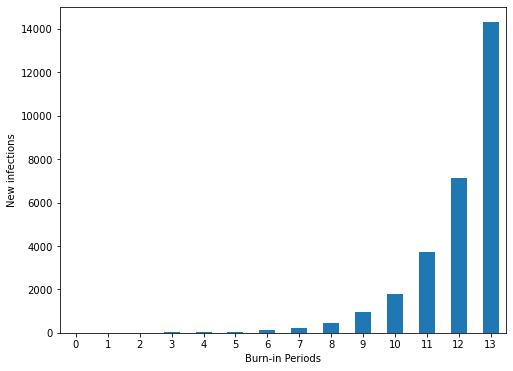

In [9]:
fig, ax = plt.subplots(figsize=(8, 6))

states.groupby("cd_ever_infected")["ever_infected"].sum().drop(index=-15).plot(
    kind="bar", ax=ax
)

ax.set_xticklabels(range(0, 14), rotation=0)
ax.set_xlabel("Burn-in Periods")
ax.set_ylabel("New infections")

plt.show()